In [2]:
import Pkg; Pkg.add("FileIO")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
   Installed FileIO ─ v1.11.2
    Updating `~/.julia/environments/v1.6/Project.toml`
  [5789e2e9] + FileIO v1.11.2
    Updating `~/.julia/environments/v1.6/Manifest.toml`
  [5789e2e9] + FileIO v1.11.2
Precompiling project...
  ✓ FileIO
  1 dependency successfully precompiled in 7 seconds (200 already precompiled)


In [4]:
import Pkg; Pkg.add("ColorTypes")

   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [3da002f7] + ColorTypes v0.11.0
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [6]:
import Pkg; Pkg.add("Images")

   Resolving package versions...
   Installed AxisAlgorithms ──────────── v1.0.1
   Installed OpenEXR ─────────────────── v0.3.2
   Installed ImageAxes ───────────────── v0.6.9
   Installed ColorVectorSpace ────────── v0.9.7
   Installed Images ──────────────────── v0.24.1
   Installed TensorCore ──────────────── v0.1.1
   Installed IndirectArrays ──────────── v0.5.1
   Installed Inflate ─────────────────── v0.1.2
   Installed ComputationalResources ──── v0.3.2
   Installed PkgVersion ──────────────── v0.1.1
   Installed TiffImages ──────────────── v0.5.2
   Installed ProgressMeter ───────────── v1.7.1
   Installed OpenEXR_jll ─────────────── v3.1.1+0
   Installed Rotations ───────────────── v1.0.4
   Installed CatIndices ──────────────── v0.2.2
   Installed ImageMetadata ───────────── v0.9.5
   Installed Ratios ──────────────────── v0.4.2
   Installed Netpbm ──────────────────── v1.0.1
   Installed Imath_jll ───────────────── v3.1.2+0
   Installed ImageDistances ──────────── v0.2.13
 

SVD Image Compression Demo for HW in EECS 551  
??? Original version by ???  
2021-10-28 Julia 1.6.3 updates by Jeff Fessler (eliminate WebIO and Interact)

In [2]:
using MIRTjim

In [3]:
# packages used; you may need to add some of these
using LinearAlgebra: svd, rank, Diagonal
using FileIO
using ColorTypes
using Images # if you have issues with this package, then comment it out
#using Interact
using Plots; default(markerstrokecolor=:auto)
println("Ready!")

Ready!


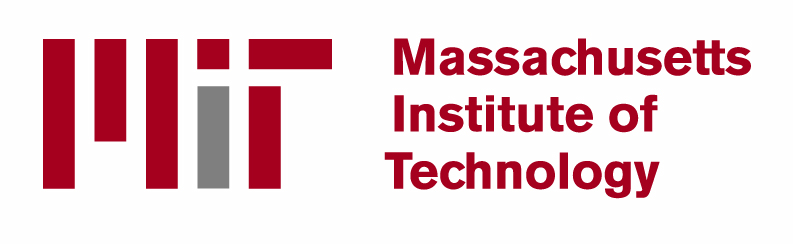

In [35]:
# Load and display an image
#image_color = load("mit.jpg") # Replace with your image -- put in the same directory as this notebook
#image_color = load("my_pic.jpg")
#image_color = load("mit_logo_nameless.jpg")
image_color = load("mit_logo_name.jpg")


size(image_color) = (244, 793)


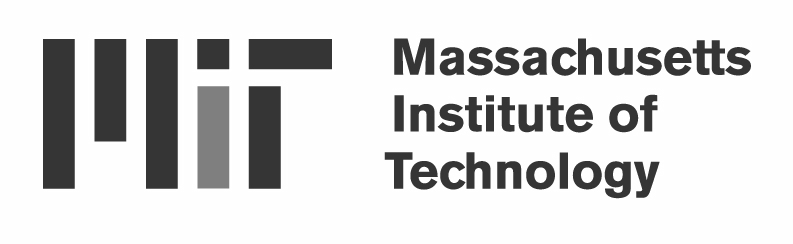

In [36]:
# Convert to gray scale for simplicity
@show size(image_color)
image_gray = Gray.(image_color)

In [37]:
# Convert to matrix of values to perform SVD
image_data = Float32.(image_gray)
typeof(image_gray)

Matrix{Gray{N0f8}} (alias for Array{Gray{Normed{UInt8, 8}}, 2})

In [38]:
# Compute SVD and rank of image matrix
U, σ, V = svd(image_data)
r = rank(Diagonal(σ)) # efficient way to find rank given singular values!
println("Rank of image matrix = $r out of $(length(σ))")

Rank of image matrix = 151 out of 244


Let $A$ be an $M \times N$ matrix having SVD

$$A = \sum_{i=1}^r \sigma_i u_i v_i',$$

where $r$ is the rank of $A$. Consider the optimization problem:

$$ \hat{A}_K = \arg \min_{X} \| A - X \|_F, \textrm{ subject to } \mathrm{rank}(X) ≤ K.$$

Via the famous Eckart-Young theorem, we have that

$$ \hat{A}_K = \sum_{i=1}^{\min(K,r)} \sigma_i u_i v_i'.$$

Mirsky showed that if we replace the Frobenius norm
in the above optimization problem by *any* unitarily invariant norm
(e.g., the operator norm, or the nuclear norm),
then the solution remains the same!

This notebook explores low-rank approximations
of an $M \times N$ sized (grayscale) image
viewed as an $M \times N$ matrix.

In [39]:
# function to compute approximation error for a k-term approximation
# to a matrix with singular values in the vector σ
function svd_rank_k_approx_error(σ, k)
    return sum(σ[(k+1):end].^2) / sum(σ.^2)
end

svd_rank_k_approx_error (generic function with 1 method)

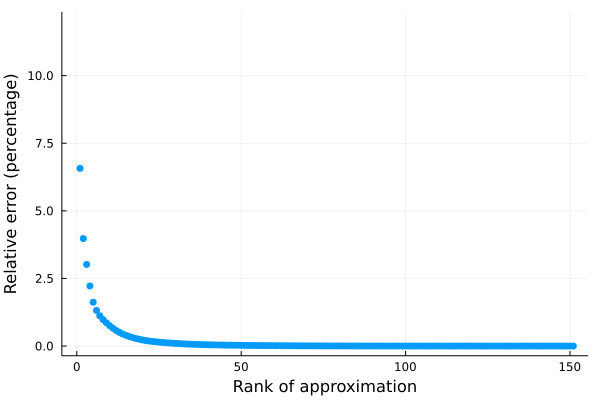

In [40]:
# Compute relative errors and plot them as a function of k
relative_error_fun = k -> svd_rank_k_approx_error(σ, k)
relative_error = relative_error_fun.(0:r)

# Plot errors
scatter(0:r, 100*relative_error, label = "",
    ylabel = "Relative error (percentage)",
    xlabel = "Rank of approximation",
	ylim = [0,12], # error at 0 is 100%
)

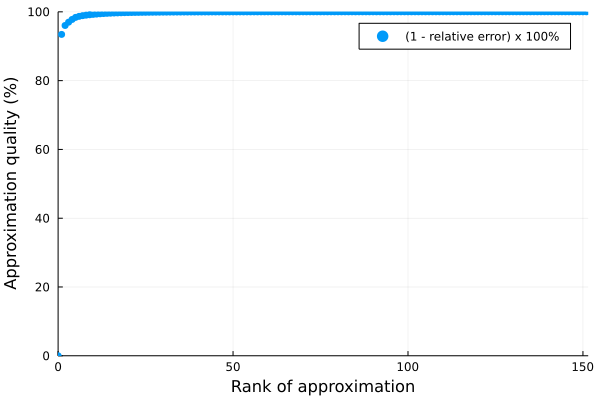

In [41]:
# Examine approximation quality vs k.
scatter(0:r, 100 * (1 .- relative_error),
    label = "(1 - relative error) x 100%",
    ylabel = "Approximation quality (%)",
    xlabel = "Rank of approximation",
    xlim = (0, r + 0.5), # adjust if needed
    ylim = (0, 100),
)

In [43]:
# See how values of k affect the visual quality of the approximation.
klist = [1, 10, 100, 800] # experiment here
ps = Array{Any}(undef, length(klist))
#@manipulate for k = klist # issues with WebIO
for (i, k) in enumerate(klist)
    image_k_matrix = U[:,1:k] * Diagonal(σ[1:k]) * V[:,1:k]'
    ps[i] = heatmap(image_k_matrix, color = :grays,
        yflip = :true, ticks = [],
        title = "K=$k, error = $(round(100*relative_error[k+1],digits=2)) %."
    )
end
plot(ps...)

LoadError: BoundsError: attempt to access 244×244 Matrix{Float32} at index [1:244, 1:800]

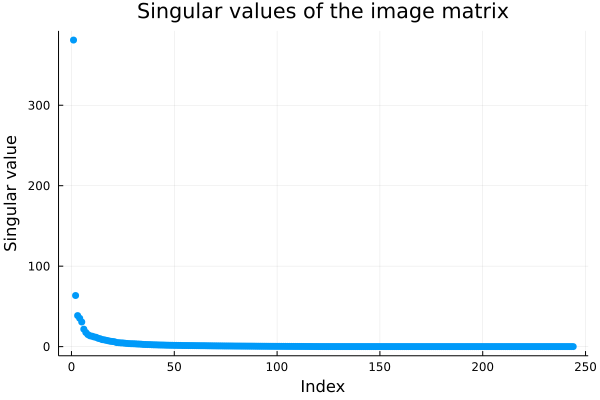

In [44]:
# plot singular values of the image
scatter(σ, label = :none,
    title = "Singular values of the image matrix",
    xlabel = "Index",
    ylabel = "Singular value",
)

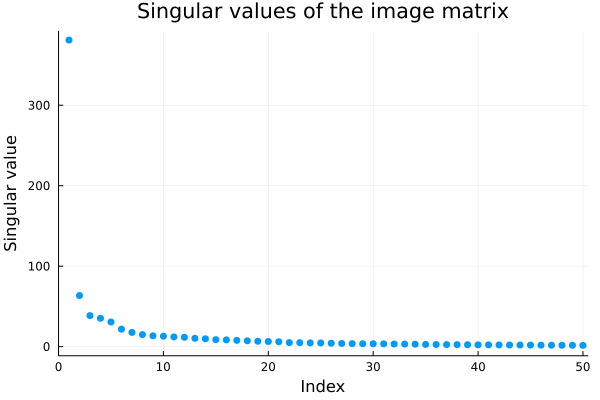

In [45]:
# Zoom in to see largest 50 singular values
ntop = 50
scatter(σ, label = :none,
    title = "Singular values of the image matrix",
    xlabel = "Index",
    ylabel = "Singular value",
    xlim = (0, ntop + 0.5),
)

In [46]:
"""
Ac, r = compress_image(A, p)
In:
* `A` `m × n` matrix
* `p` scalar in `(0, 1]`
Out:
* `Ac` a `m × n` matrix containing a compressed version of `A`
that can be represented using at most `(100 * p)%` as many bits
required to represent `A`
* `r` the rank of `Ac`
"""
function compress_image(A, p)
    m = size(A)[1]
    n = size(A)[2]
    
    (U, s, V) = svd(A)
    r = rank(Diagonal(s))
    k= Int(floor(p * m * n/(m+n+1)))
    
    r = min(r,k)
    Ac = U[:,1:r] * Diagonal(s[1:r]) * V[:,1:r]'
    
    return Ac, r
end 


compress_image

In [47]:
typeof(Int(ceil(0.2 * 34554)))
size(image_data)

(244, 793)

In [48]:
Ac, k = compress_image(image_data, 0.2)

(Float32[0.99576217 0.9963626 … 0.9960226 0.9960226; 0.99575967 0.99636024 … 0.9960202 0.9960202; … ; 0.99576 0.9963604 … 0.9960204 0.9960204; 0.99576 0.9963604 … 0.9960204 0.9960204], 37)

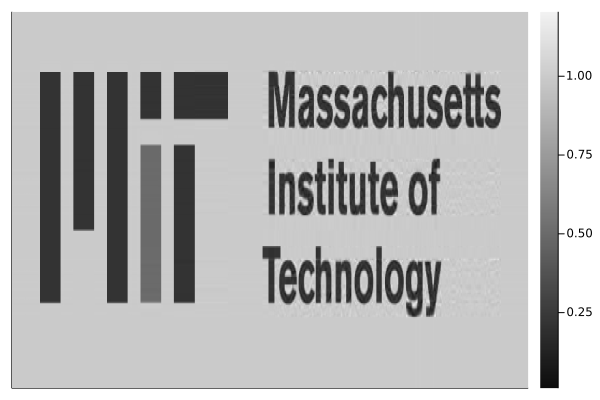

In [49]:
heatmap(Ac, color = :grays, yflip = :true, ticks = [])

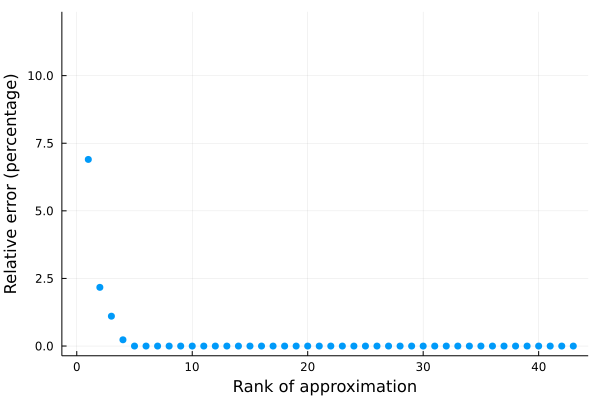

In [31]:
# Compute relative errors and plot them as a function of k
m = size(image_data)[1]
n = size(image_data)[2]
relative_error_fun = k -> svd_rank_k_approx_error(σ, k)
relative_error = relative_error_fun.(0:r)

# Plot errors
scatter(0:r, 100*relative_error, label = "",
    ylabel = "Relative error (percentage)",
    xlabel = "Rank of approximation",
	ylim = [0,12], # error at 0 is 100%
    
)

In [50]:
"""
Ac= compress_image_with_rank_k(A, k)
In:
* `A` `m × n` matrix
* `k` 
Out:
* `Ac` a `m × n` matrix containing a compressed version of `A`
that can be represented using at most `(100 * p)%` as many bits
required to represent `A`
"""
function compress_image_with_rank_k(A, k)
    (U, s, V) = svd(A)
    Ac = U[:,1:k] * Diagonal(s[1:k]) * V[:,1:k]'
    
    return Ac
end 


compress_image_with_rank_k

In [51]:
Ac = compress_image_with_rank_k(image_data, 5)

244×793 Matrix{Float32}:
 0.995772  0.996414  0.996074  0.995891  …  0.996048  0.996049  0.996049
 0.995769  0.996411  0.996072  0.995888     0.996045  0.996046  0.996046
 0.99577   0.996411  0.996072  0.995888     0.996045  0.996046  0.996046
 0.995769  0.996411  0.996072  0.995888     0.996045  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888  …  0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888  …  0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 0.99577   0.996412  0.996072  0.995888     0.996046  0.996046  0.996046
 ⋮                        

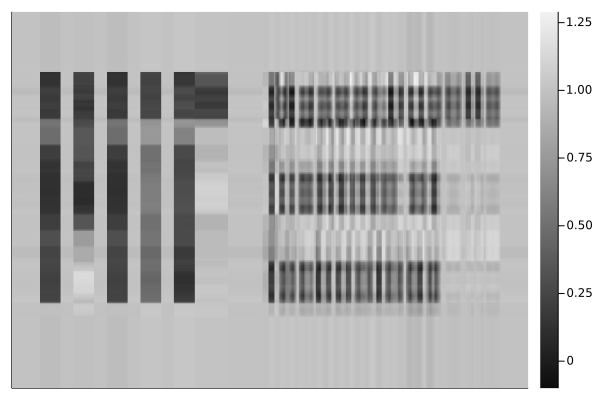

In [52]:
heatmap(Ac, color = :grays, yflip = :true, ticks = [])

Probably your image matrix seems to have the spectral signature
of a low-rank-signal-plus-noise type of matrix.
In this problem we do "better" in terms of approximating the image
as the rank parameter increases.
This makes it an approximation type problem.

If we were to add noise to this image
and then measure error relative to the noise-free image,
then we would see that
if the noise is large enough
then the error is best
when the approximation rank is less than the rank of signal-plus-noise matrix;
that would be a denoising problem
and insights from random matrix theory are invaluable there.
Determining whether one is operating in a denoising setup
versus an approximation setup is not always straightforward.
We say more to say about this later.

In [18]:
# ## Optional below here
#
# Extract individual RGB channels
using Images: channelview, rawview
image_mtx = rawview(channelview(image_color)).data
red_image = Float32.(image_mtx[1,:,:])
green_image = Float32.(image_mtx[2,:,:])
blue_image = Float32.(image_mtx[3,:,:])

1000×2000 Matrix{Float32}:
 0.243137   0.247059   0.219608   …  0.72549    0.721569   0.721569
 0.47451    0.403922   0.32549       0.752941   0.745098   0.713726
 0.670588   0.552941   0.47451       0.733333   0.721569   0.67451
 0.854902   0.788235   0.694118      0.709804   0.721569   0.717647
 0.717647   0.647059   0.54902       0.65098    0.678431   0.705882
 0.745098   0.694118   0.619608   …  0.65098    0.658824   0.67451
 0.917647   0.823529   0.709804      0.623529   0.643137   0.686275
 0.784314   0.772549   0.745098      0.447059   0.509804   0.596078
 0.596078   0.690196   0.67451       0.411765   0.403922   0.454902
 0.466667   0.572549   0.615686      0.423529   0.388235   0.384314
 0.654902   0.627451   0.537255   …  0.45098    0.45098    0.47451
 0.509804   0.529412   0.552941      0.545098   0.533333   0.45098
 0.509804   0.52549    0.533333      0.505882   0.501961   0.466667
 ⋮                                ⋱                        
 0.133333   0.133333   0.121569  

#### Optional question

What if we perform low-rank approximations of R, G and B matrices separately
and then combine them?
Is that approach "better" in any sense?

#### Optional question

What if we did the SVD on "patches" of the image
instead of the entire image?
A [p,q] patch of an image is a p x q rectangular subimage taken from the image.
In the patch-based approach one can imagine slicing the image up
into lots of (non-overlapping, for starters) patches,
computing an SVD of the individual patches,
and stitching them back together.
How does that work?
Try it and let us know!
You'll have to implement (or find) a Julia analog of
https://www.mathworks.com/help/images/ref/im2col.html